# Quantum Teleportation with Qiskit

This Python3 notebook uses the Qiskit quantum computing framework to give an introduction to the concept of quantum teleportation.

---

## Dependencies

The dependencies for this notebook are listed below. You can install them in your Python3 environment with ``pip3 install <package>``:

In [1]:
import qiskit
import numpy
import matplotlib

(Expand this cell to see the Latex macros)$
\newcommand{\vect}[1]{{\mathbf{\boldsymbol{{#1}}}}}
\newcommand{\ket}[1]{{\mid {#1}\rangle}}
\newcommand{\bra}[1]{{\langle {#1} \mid}}
\newcommand{\bv}[1]{\mathbf{#1}}
\newcommand{\mat}[1]{\begin{bmatrix} #1 \end{bmatrix}}
\newcommand{\comm}[2]{\left[ #1, #2 \right]}
\newcommand{\anticomm}[2]{\left\lbrace #1, #2 \right\rbrace}
\newcommand{\tr}{\text{tr}}
\newcommand{\id}{\mathbf{1}}
$


### Additional Import Statements

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector
from qiskit.providers.aer import StatevectorSimulator

## Quantum Teleportation


In [3]:
def prepare_bell_state(circuit, a, b):
    """Prepares a Bell state from two qubits"""
    
    # apply Hadamard operation to qubit a:
    circuit.h(a)
    
    # apply CNOT operation to qubit b with control qubit a:
    circuit.cx(a, b)

In [4]:
def prepare_transmitted_qubit(circuit, psi, a):
    """Prepares a qubit 'psi' for transmission"""
    
    # apply a CNOT operation to qubit a with controll qubit psi
    circuit.cx(psi,a)
    

In [5]:
def measure_and_transmit(circuit, psi, a, c_x=0, c_z=1):
    """ Measures and transmits qubits over a classical channel"""
    
    # measure psi in the X basis:
    # (Note: this is the same as applying H, then measuring in
    #  the Z basis)
    circuit.h(psi)
    circuit.measure(psi,c_z)
    circuit.barrier()
    
    # measure bell state bit in Z basis:
    circuit.measure(a,c_x)

In [6]:
def reconstruct_qubit(circuit, b, x_bit, z_bit):
    """ reconstructs the 'teleported' qubit"""
    
    # apply observed X and Z transformations to the
    # other bell state bit:
    circuit.x(b).c_if(x_bit, 1)
    circuit.z(b).c_if(z_bit, 1)

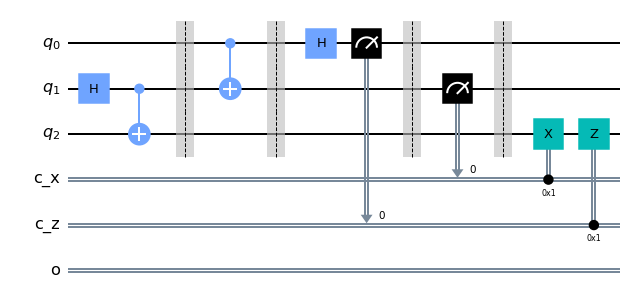

In [7]:

# initialize registers and circuit:
qreg = QuantumRegister(3, name='q')
creg_x = ClassicalRegister(1, name='c_x')
creg_z = ClassicalRegister(1, name='c_z')
creg_out = ClassicalRegister(1, name='o')
teleportation_circuit = QuantumCircuit(qreg, creg_x, creg_z, creg_out)

# Step 1: Create Bell pair
prepare_bell_state(teleportation_circuit, 1, 2)
teleportation_circuit.barrier()

# Step 2: Prepare the transmitted qubit:
prepare_transmitted_qubit(teleportation_circuit, 0, 1)
teleportation_circuit.barrier()

# Step 3: Measure and send two classical bits:
measure_and_transmit(teleportation_circuit, 0, 1)
teleportation_circuit.barrier()

# Step 4: reconstruct transmitted qubit:
reconstruct_qubit(teleportation_circuit, 2, creg_x, creg_z)

teleportation_circuit.draw(output='mpl')


## Simulating this Circuit:


In [8]:
import numpy as np

def init_psi_qubit(circuit, psi):
    circuit.ry(np.pi/3, 0)

In [9]:
def build_teleportation_circuit(measure_axis='z'):
    """ Builds a quantum teleportation circuit"""
    
    assert(measure_axis in ['x', 'z'])
    
    # initialize registers and circuit:
    qreg = QuantumRegister(3, name='q')
    creg_x = ClassicalRegister(1, name='c_x')
    creg_z = ClassicalRegister(1, name='c_z')
    creg_out = ClassicalRegister(1, name='o')
    circuit = QuantumCircuit(qreg, creg_x, creg_z, creg_out)

    # Step 0: Initialize psi to something interesting:
    init_psi_qubit(circuit, 0)


    # Step 1: Create Bell pair
    prepare_bell_state(circuit, 1, 2)
    circuit.barrier()

    # Step 2: Prepare the transmitted qubit:
    prepare_transmitted_qubit(circuit, 0, 1)
    circuit.barrier()

    # Step 3: Measure and send two classical bits:
    measure_and_transmit(circuit, 0, 1)
    circuit.barrier()

    # Step 4: reconstruct transmitted qubit (and measure):
    reconstruct_qubit(circuit, 2, creg_x, creg_z)
    if measure_axis == 'x':
        circuit.h(2)
    circuit.measure(2, 2)
    
    return circuit

def build_control_circuit(measure_axis='z'):
    """ Builds a 'control' circuit"""
    
    assert(measure_axis in ['x', 'z'])
    
    qreg = QuantumRegister(1, name='q')
    creg_out = ClassicalRegister(1,name='o')
    circuit = QuantumCircuit(qreg, creg_out)
    
    # initialize qubit then immediately measure:
    init_psi_qubit(circuit, 0)
    if measure_axis == 'x':
        circuit.h(0)
    circuit.measure(0, 0)
    
    return circuit
    

Control Circuit (measuring in Z basis):


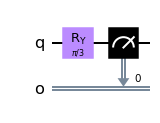

In [10]:
control_x = build_control_circuit(measure_axis='x')
control_z = build_control_circuit(measure_axis='z')

teleport_x = build_teleportation_circuit(measure_axis='x')
teleport_z = build_teleportation_circuit(measure_axis='z')

print('Control Circuit (measuring in Z basis):')
control_z.draw(output='mpl')


Teleportation Circuit (measuring in Z basis):


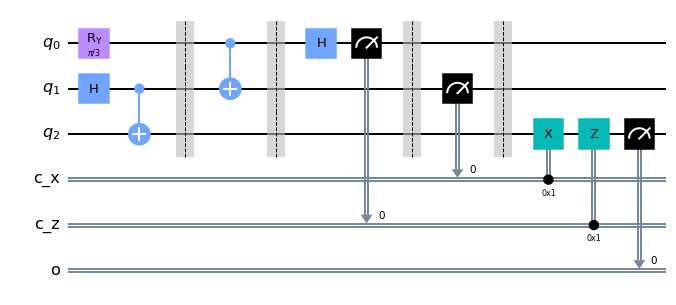

In [11]:
print('Teleportation Circuit (measuring in Z basis):')
teleport_z.draw(output='mpl')

In [12]:
def simulate_circuit(circuit, output_bits):
    sim = Aer.get_backend('qasm_simulator')
    tqc = transpile(circuit, sim)
    counts = sim.run(tqc).result().get_counts(circuit)
    return marginal_counts(counts, output_bits)
    

# run the control experiments:
control_x_results = simulate_circuit(control_x, [0])
control_z_results = simulate_circuit(control_z, [0])

# run the teleportation experiments:
teleport_x_results = simulate_circuit(teleport_x, [2])
teleport_z_results = simulate_circuit(teleport_z, [2])

In [13]:
import matplotlib.pyplot as plt

def plot_results(results_list, labels, title='Results',
                 keys = ['0', '1'],
                 bars=[r'$|0\rangle$',r'$|1\rangle$']):
    plt.figure(figsize=(8,6))
    plt.title(title, fontsize=16)
    plt.xticks(list(range(len(bars))), bars, fontsize=16)
    plt.ylabel('Measurement Probability',fontsize=16)
    n = len(keys)
    
    for i, (result, label) in enumerate(zip(results_list, labels)):
        x = np.arange(n,dtype=np.float64)
        x += ((i/n) - 0.25) / 1.5
        w = (1/n)*0.6
        y = np.array([result[k] for k in keys],dtype=np.float64)
        y /= np.sum(y)
        plt.bar(x,y,w, label=label)
    plt.legend()
    plt.show()


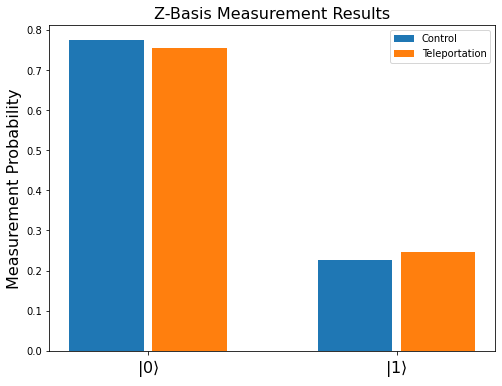

In [14]:
plot_results([control_z_results, teleport_z_results],
             ['Control', 'Teleportation'],
             'Z-Basis Measurement Results')

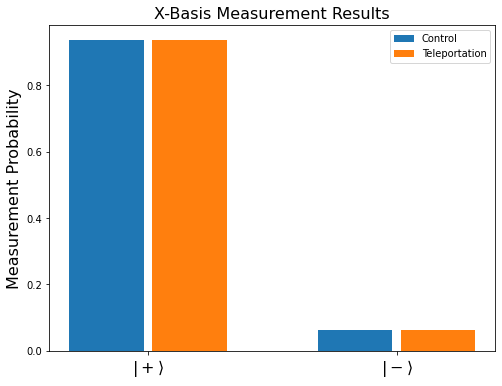

In [15]:
plot_results([control_x_results, teleport_x_results],
             ['Control', 'Teleportation'],
             'X-Basis Measurement Results',
              bars=[r'$|+\rangle$',r'$|-\rangle$'])